## _*H2 ground state energy computation using Quantum Phase Estimation*_

This notebook demonstrates using Qiskit Chemistry to compute ground state energy of the Hydrogen (H2) molecule using QPE (Quantum Phase Estimation) algorithm. Let's look at how to carry out such computation programmatically.

This notebook has been written to use the PYSCF chemistry driver.

### Step 1: Map problem to quantum circuits and operators

In [44]:
import numpy as np
from scipy.linalg import expm

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import HartreeFock

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms import PhaseEstimation

from qiskit.primitives import Sampler
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService

We first set up the H2 molecule, create the fermionic and in turn the qubit operator using PySCF.

In [2]:
driver = PySCFDriver(atom='H .0 .0 .0; H .0 .0 0.735', basis='sto3g')
molecule = driver.run()
hamiltonian = molecule.hamiltonian.second_q_op()
mapper = ParityMapper(num_particles=molecule.num_particles)
tapered_mapper = molecule.get_tapered_mapper(mapper)
qubit_op = tapered_mapper.map(hamiltonian)

Using a classical exact eigenvalue solver, we can establish the reference groundtruth value of the ground state energy:

In [6]:
exact_eigensolver = NumPyMinimumEigensolver()
exact_eigensolver.filter_criterion = molecule.get_default_filter_criterion()
gse = GroundStateEigensolver(mapper, exact_eigensolver)
result = gse.solve(molecule)
print(f'The exact ground state energy is: {result.eigenvalues[0]} Ha')

The exact ground state energy is: -1.8572750302023788 Ha


Next we set up the QPE algorithm instance using the HartreeFock initial state:

In [28]:
qpe = PhaseEstimation(9, Sampler())

state_in = HartreeFock(molecule.num_spatial_orbitals, molecule.num_particles, tapered_mapper)
U = UnitaryGate(expm(1j*qubit_op.to_matrix()))

result = qpe.estimate(U, state_in)

print(f'Ground state energy from QPE: {(result.phase - 1) * 2*np.pi} Ha')

Ground state energy from QPE: -1.8530487917658545 Ha


As can be easily seen, the QPE computed energy is quite close to the groundtruth value we computed earlier.

### Step 2: Optimize for target hardware

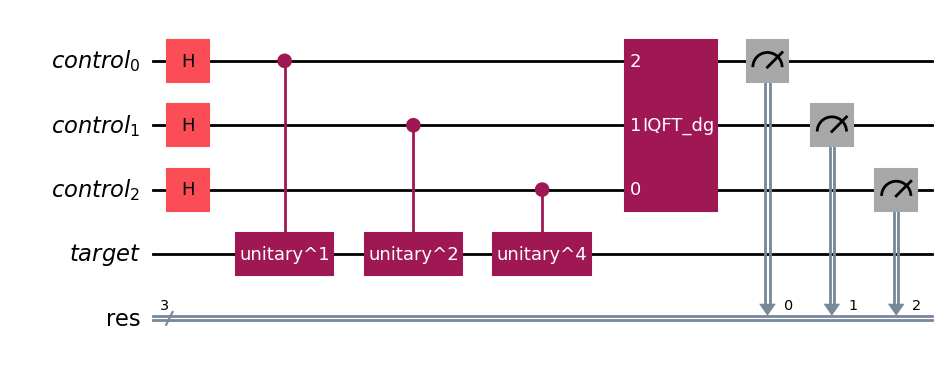

In [42]:
num_result_bits = 3
qpe = PhaseEstimation(num_result_bits, Sampler())

qr1 = QuantumRegister(num_result_bits, 'control')
qr2 = QuantumRegister(1, 'target')
cr = ClassicalRegister(num_result_bits, 'res')
circuit = QuantumCircuit(qr1, qr2, cr)
circuit.compose(qpe.construct_circuit(U, state_in), inplace=True)
circuit.measure(qr1, cr)
circuit.decompose().draw('mpl')

In [46]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

isa_circuit = pm.run(circuit)
isa_circuit.count_ops()

ibm_sherbrooke


OrderedDict([('rz', 76), ('sx', 50), ('ecr', 16), ('measure', 3)])

### Step 3: Execute on target hardware

In [47]:
sampler = Sampler(mode=backend)

job = sampler.run([isa_circuit]).result()

id = job.job_id()
print(id)

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='***'
)
job = service.job('cvsxcwvy6y80008bknsg')
job_result = job.result()